In [42]:
'''
Interpretable clustering: https://towardsdatascience.com/interpretable-clustering-39b120f95a45 
Explainable K-Means Clustering: https://github.com/navefr/ExKMC --> Requires MS Visual C++
Uncertainty visualization: https://diglib.eg.org/handle/10.2312/trvis20191183
Bokeh interactive charting: https://docs.bokeh.org/en/latest/index.html
KPrototype = https://medium.com/datadriveninvestor/k-prototype-in-clustering-mixed-attributes-e6907db91914
KMode = https://github.com/nicodv/kmodes
KPrototype = KMeans + KModes
Elbow, Silhouette = https://towardsdatascience.com/hierarchical-clustering-on-categorical-data-in-r-a27e578f2995
Cluster 3D plot: https://thatascience.com/learn-machine-learning/kmeans/
Interactive Cluster Plot: https://www.bigendiandata.com/2017-04-18-Jupyter_Customer360/
Subplot: 
https://stackoverflow.com/questions/3584805/in-matplotlib-what-does-the-argument-mean-in-fig-add-subplot111
https://stackoverflow.com/questions/48884280/plot-2-3d-surface-side-by-side-using-matplotlib
https://buzzrobot.com/dominant-colors-in-an-image-using-k-means-clustering-3c7af4622036
'''
'''
Query to filter out:
SELECT FLIEF, EKORG, COUNT(DISTINCT(BANFN)) AS PRs
       FROM "SAPABAP1"."EBAN" 
       WHERE BANFN in ('comma seperated PR#')
       GROUP BY FLIEF, EKORG
       HAVING count(distinct(BANFN)) > 5
       ORDER BY FLIEF, EKORG
'''
'''
Measuring cluster quality:
https://stats.stackexchange.com/questions/21807/evaluation-measures-of-goodness-or-validity-of-clustering-without-having-truth
(Extrensic Vs Intrinsic Or External Index Vs Internal index)
https://scikit-learn.org/stable/modules/clustering.html#clustering-performance-evaluation

Finding through Internal Index cluster quality:
    - SSE: sum of the square error from the items of each cluster.
    - Inter cluster distance: sum of the square distance between each cluster centroid.
    - Intra cluster distance for each cluster: sum of the square distance from the items of each cluster to its centroid.
    - Maximum Radius: largest distance from an instance to its cluster centroid.
    - Average Radius: sum of the largest distance from an instance to its cluster centroid divided by the number of clusters.
    - Silhouette Coefficient: The Silhouette function will compute the mean Silhouette Coefficient of all samples using the mean intra-cluster distance and the mean nearest-cluster distance for each sample.
    - Davies-Bouldin
    - Calinski-Harabasz
    - Dunn index
    - R-squared index
    - Hubert-Levin (C-index)
    - Krzanowski-Lai index
    - Hartigan index
    - Root-mean-square standard deviation (RMSSTD) index
    - Semi-partial R-squared (SPR) index
    - Distance between two clusters (CD) index
    - weighted inter-intra index
    - Homogeneity index
    - Separation index    
'''
#import pyhdb as db
from hdbcli import dbapi
import pandas as pd
import os
from kmodes.kprototypes import KPrototypes
from kmodes.kmodes import KModes
import matplotlib.pyplot as plt
from matplotlib import style
from mpl_toolkits.mplot3d import Axes3D
from pandas.api.types import is_string_dtype
from pandas.api.types import is_numeric_dtype
import numpy as np
import time
from scipy.spatial.distance import cosine
from sklearn.metrics import silhouette_score
from sklearn.metrics import pairwise_distances
from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics import davies_bouldin_score
from sklearn.tree import DecisionTreeClassifier 
from sklearn import tree
from dtreeviz.trees import dtreeviz
import graphviz
from IPython.core.display import display, HTML
from sklearn.ensemble import RandomForestClassifier as rfc
from lime.lime_tabular import LimeTabularExplainer 
from sklearn.cluster import MiniBatchKMeans

'''
ML interpretibility (LIME/Shapey values)

-- Combined
Step 1: Identifyng the right clustering algorithm --> Pickle model
Step 2: Explore ML interpretibility/explanation options (ouput of 1, becomes input to 2) --> Pickle ML interpretibility

-- Kishan
Step 3: Python Flask REST endpoint
Step 4: REST endpoint to Call algorithm (Date range input) --> Call Step 1 algorithm
Step 5: REST endpoint to expose the ML interpretibilty/explainability --> Call step 2
-------------------------------------------------------------------------------

-- Pritam
Step 6: UI Application to select the date range (before clustering/Input date range)  
Step 7: Some button to trigger the model --> Date range input to Step 4
Step 8: Some button to show ML explainability --> Triggers Step 5
Step 9: UI to show the list PR's which can be bundled (attributes) --> Interactive charts ?
Step 9': ML explanations to be showcased
Step 10: Date range for bundling to PO (Optional as we need PO creation time.)

Timeline in plan:
    - First draft: 09/Oct/2020 (Showcase to Unni/Thomas for confirmation)
    - Incorporating additional comments and Integration: 16/Oct/2020 
    - Tieing up loose ends: 23/Oct/2020
    - Plan for an demo: Before 30/Oct/2020
'''

style.use("ggplot")

HOST = os.getenv("HOST")
PORT = os.getenv("PORT")
USER = os.getenv("USER")
PASSWORD = os.getenv("PASSWORD")
ORIG_SCHEMA = os.getenv("SCHEMA")

flief = {}
ekorg = {}
ekgrp = {}
CONFIDENCE_LEVEL = 0.95
NO_OF_CLUSTER = 6
THRESHOLD_PR_GROUP = 5

In [43]:
'''
Assumption:
    a) Account Assignment <> Blank Or Unassigned
    b) Status not in ‘RFQ created’, ‘PO created’, ‘Contract Created’,  and ‘Scheduling Agreement Created’
    c) PO is not yet assigned
    d) PR created by purchasing team (Direct/Indirect) --> ESTKZ in ('R', 'S')
    e) PR's not marked as deleted --> LOEKZ NOT IN ('X')

'''
def getOpenPRs():
    #connection = db.connect(HOST, PORT, USER, PASSWORD)
    connection = dbapi.connect(HOST, PORT, USER, PASSWORD)
    SQL_Query = pd.read_sql_query(
    """SELECT MANDT, BANFN, BNFPO, FLIEF, EKORG, EKGRP
       FROM "SAPABAP1"."EBAN" 
       WHERE STATU NOT IN ('A', 'B', 'E', 'K', 'L') 
           AND EBELN = '' 
           AND ESTKZ in ('R', 'S') 
           AND KNTTP NOT IN ('','U') 
           AND LOEKZ NOT IN ('X')
           AND LFDAT >= 20180401 AND LFDAT <= 20181231 """, connection)
    
    originalData = pd.DataFrame(SQL_Query, columns=['MANDT', 'BANFN', 'BNFPO', 'FLIEF', 'EKORG', 'EKGRP'])
    print(originalData.head())
    print(originalData.info())
    print(originalData.describe())
    return originalData 

def getFeatureList(data):
    colIndex = 0
    numericalColNames = []
    numericalColIndex = []
    categoricalColNames = []
    categoricalColIndex = []
    
    for col in data.columns:
        if (is_string_dtype(data[col])):
            categoricalColNames.append(col)
            categoricalColIndex.append(colIndex)
        elif (is_numeric_dtype(data[col])):
            numericalColNames.append(col)
            numericalColIndex.append(colIndex)
        colIndex = colIndex + 1 
    print("Numerical Columns") 
    print(numericalColNames)
    print("Categorical Columns") 
    print(categoricalColNames)
    return (numericalColNames, numericalColIndex, categoricalColNames, categoricalColIndex)    

def getBestKMode(data):
    distortions = []
    K = range(1,NO_OF_CLUSTER)
    for k in K:
        kmodes = KModes(n_clusters=k, init='Cao', n_init=5, verbose=2)
        kmodes.fit_predict(data)
        print("k:",k, " cost:", kmodes.cost_)
        distortions.append(kmodes.cost_)
    # Plot the elbow
    plt.plot(K, distortions, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Distortion')
    plt.title('The Elbow Method showing the optimal k')
    plt.savefig("bestkmode.png", bbox_inches='tight', dpi=100)      
    plt.show()
    

def getBestKPrototype(data, categoricalColIndex):
    distortions = []
    K = range(1,NO_OF_CLUSTER)
    for k in K:
        kproto = KPrototypes(n_clusters=k, init='Cao', verbose=2)
        kproto.fit_predict(data)
        print("k:",k, " cost:", kproto.cost_)
        distortions.append(kproto.cost_)
    # Plot the elbow
    plt.plot(K, distortions, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Distortion')
    plt.title('The Elbow Method showing the optimal k')
    plt.savefig("bestkprototype.png", bbox_inches='tight', dpi=100)    
    plt.draw()

def computeDataUniqueness(data):
    print("computing unique data list for FLIEF")
    flief.update(getDataUniqueValue(data["FLIEF"].unique().tolist()))
    
    print("computing unique data list for EKORG")
    ekorg.update(getDataUniqueValue(data["EKORG"].unique().tolist()))
    
    print("computing unique data list for EKGRP")    
    ekgrp.update(getDataUniqueValue(data["EKGRP"].unique().tolist()))
    print(len(flief), len(ekorg), len(ekgrp))

def getDataUniqueValue(data):
    dataMap = {}
    count = 0
    for value in data:
        dataMap[value] = count
        count = count + 1
    return dataMap
    
def executeKProtoTypeCluster(data, categoricalColIndex, k):
    kproto = KPrototypes(n_clusters=k, init='Cao', verbose=2)
    clusters = kproto.fit_predict(data, categorical=categoricalColIndex)
    # Print cluster centroids of the trained model.
    print("===============================================")
    centroids = kproto.cluster_centroids_
    print("Cluster Centroids:")
    print(centroids)
    labels = kproto.labels_
    print("Labels:")    
    print(labels)
    print("===============================================")        
    # Print training statistics
#     print(kproto.cost_)
#     print(kproto.n_iter_)
#     print(kproto.labels_)
    return (clusters, centroids, labels)

def executeKModeCluster(data, k):
    kmodes = KModes(n_clusters=k, init='Cao', n_init=5, verbose=2)
    clusters = kmodes.fit_predict(data)
    # Print the cluster centroids
    print("===============================================")
    centroids = kmodes.cluster_centroids_
    print("Cluster Centroids:")
    print(centroids)
    labels = kmodes.labels_
    print("Labels:")    
    print(labels)
    print("===============================================")        
    # Print training statistics
#     print(kmodes.cost_)
#     print(kmodes.n_iter_)
#     print(kmodes.labels_)
    return (clusters, centroids, labels)

def replaceCentroidsWithUniqueness(centroids):
    cenSimilarity = []
    for cenRow in centroids:
        cenData = []
        cenData.append(flief.get(cenRow[0]))
        cenData.append(ekorg.get(cenRow[1]))
        cenData.append(ekgrp.get(cenRow[2]))
        cenSimilarity.append(cenData)
    return cenSimilarity

def computeSimilarity(dataSim, data, cenSimilarity, clusters):
    cosine = []
    ''' Replace computed uniqueness value of categorical features '''
    for i in range(len(data)):
        dataSim.loc[i, "FLIEF"] = flief.get(data.loc[i, "FLIEF"])
        dataSim.loc[i, "EKORG"] = ekorg.get(data.loc[i, "EKORG"])
        dataSim.loc[i, "EKGRP"] = ekgrp.get(data.loc[i, "EKGRP"])
        ''' Compute cosine similarity '''
        cosine.append(cosineSimilarity(dataSim.iloc[i], cenSimilarity[clusters[i]]))
#         sim = [dataSim.loc[i, "FLIEF"], dataSim.loc[i, "EKORG"], dataSim.loc[i, "EKGRP"]]
#         cosine.append(cosineSimilarityLib(sim, cenSimilarity[clusters[i]]))
    return (cosine, dataSim)
    
def cosineSimilarity(a, b):
    cosValue = 0.0
    dot = np.dot(a, b)
    if(dot != 0 ):
        norma = np.linalg.norm(a)
        normb = np.linalg.norm(b)
        if(norma != 0 and normb != 0): 
            cosValue = dot / (norma * normb)
    return cosValue 

def cosineSimilarityLib(a, b):
    return (1 - cosine(a, b))

def groupClusteredPRs(originalData, dataCnv, clusters):
    filteredClusters = []    
    columnNames = ['FLIEF', 'EKORG', 'EKGRP']
    filteredRows = pd.DataFrame(columns=columnNames)
    groupPRs = {}
    for i in range(len(originalData)):
        if(originalData.loc[i, "cosine"] >= CONFIDENCE_LEVEL):
            filteredRows.loc[i, 'FLIEF'] = dataCnv.loc[i, 'FLIEF']
            filteredRows.loc[i, 'EKORG'] = dataCnv.loc[i, 'EKORG']
            filteredRows.loc[i, 'EKGRP'] = dataCnv.loc[i, 'EKGRP']
            filteredClusters.append(clusters[i])            
            
            if(groupPRs.get(originalData.loc[i, "cluster"]) == None):
                clusterPRs = []
                clusterPRs.append(originalData.loc[i, "BANFN"])
                groupPRs[originalData.loc[i, "cluster"]] = clusterPRs
            else:
                clusterPRs = groupPRs.get(originalData.loc[i, "cluster"])
                if(originalData.loc[i, "BANFN"] not in clusterPRs):
                    clusterPRs.append(originalData.loc[i, "BANFN"])
    return (groupPRs, filteredRows, filteredClusters)

def filterPRs(groupPRs):
    filteredPRs = {}
    ''' Filter PRs with some threshold values '''
    for i in range(NO_OF_CLUSTER):
        if (groupPRs.get(i) != None and len(groupPRs.get(i)) >= THRESHOLD_PR_GROUP):
            filteredPRs[i] = groupPRs.get(i)
    return filteredPRs

def drawMultiplePlotClusters(dataSet, clusters, selectedPRs, selectedClusters, centroids):
    ''' Position FLIEF = 0, EKORG = 1, EKGRP = 2 '''    
    FLIEF = 0 
    EKORG = 1 
    EKGRP = 2
    colors = [[255, 227, 3], #Yellow 
              [0, 139, 69], #Green
              [0, 0, 255], #Blue
              [0,255,255], #Cyan
              [255, 0, 255], #Meganta
              [255,165,0] #Orange
             ] 
    #Plot the clusters obtained using k means
    print(centroids[:, FLIEF])
    print(centroids[:, EKORG])
    print(centroids[:, EKGRP])
    
    fig = plt.figure(figsize=(16, 12))
    fig.suptitle('Comparison plot of All clustered PRs Vs Selected PRs')
    ax1 = fig.add_subplot(221, projection='3d') #221=top left
    for cluster, data in zip(clusters, dataSet_norm):
        ax1.scatter(data[FLIEF], data[EKORG], data[EKGRP], color = rgb_to_hex(colors[cluster]))
        
    ax1.scatter(centroids[:, FLIEF],
                centroids[:, EKORG],
                centroids[:, EKGRP],
                s = 50,
                marker='o',
                c='red',
                label='Centroids')
    
    ax1.set_title('PRs Clustering')
    ax1.set_xlabel('FLIEF')
    ax1.set_ylabel('EKORG')
    ax1.set_zlabel('EKGRP')
    ax1.legend(loc='upper left')
    
    ax2 = fig.add_subplot(223, projection='3d') #223=bottom left   
    for cluster, data in zip(selectedClusters, selectedPRs):
        ax2.scatter(data[FLIEF], data[EKORG], data[EKGRP], color = rgb_to_hex(colors[cluster]))
    
    ax2.scatter(centroids[:, FLIEF],
                centroids[:, EKORG],
                centroids[:, EKGRP],
                s = 50,
                marker='o',
                c='red',
                label='Centroids')
    
    ax2.set_title('PRs Clustering')
    ax2.set_xlabel('FLIEF')
    ax2.set_ylabel('EKORG')
    ax2.set_zlabel('EKGRP')
    ax2.legend(loc='upper left')    
    
    plt.tight_layout()
    plt.savefig("prrec.png", bbox_inches='tight', dpi=100)    
    plt.draw()

def rgb_to_hex(rgb):
    return '#%02x%02x%02x' % (int(rgb[0]), int(rgb[1]), int(rgb[2]))

In [44]:
''' Step1: Get all open PRs '''
print('Getting open PRs....')
originalData = getOpenPRs()
data = originalData.copy()
''' We don't need primary keys for computing clusters '''
data.drop(['MANDT', 'BANFN', 'BNFPO'], axis = 1, inplace = True)        

Getting open PRs....
  MANDT       BANFN  BNFPO FLIEF EKORG EKGRP
0   100  0518538842  00010        KR01   AJA
1   100  0522476266  00010               OC5
2   100  0517585602  00030               UWE
3   100  0512703893  00030        BE25   OAG
4   100  0512331530  00010        DE1M   DUV
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3860 entries, 0 to 3859
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   MANDT   3860 non-null   object
 1   BANFN   3860 non-null   object
 2   BNFPO   3860 non-null   object
 3   FLIEF   3860 non-null   object
 4   EKORG   3860 non-null   object
 5   EKGRP   3860 non-null   object
dtypes: object(6)
memory usage: 181.1+ KB
None
       MANDT       BANFN  BNFPO FLIEF EKORG EKGRP
count   3860        3860   3860  3860  3860  3860
unique     1        1686    230   375   126   364
top      100  0522497585  00010               SP5
freq    3860         106   1211  2931  1448   298


In [45]:
''' Step2: Get categorical and numerical features '''
print('Checking numerical/categorical features....')    
featureList = getFeatureList(data)
numericalColNames = featureList[0]
numericalColIndex = featureList[1]
categoricalColNames = featureList[2]
categoricalColIndex = featureList[3]

Checking numerical/categorical features....
Numerical Columns
[]
Categorical Columns
['FLIEF', 'EKORG', 'EKGRP']


In [46]:
''' Step3: Compute categorical data uniqueness '''
print('Compute categorical data uniqueness....')
computeDataUniqueness(data)

Compute categorical data uniqueness....
computing unique data list for FLIEF
computing unique data list for EKORG
computing unique data list for EKGRP
375 126 364


Depict elbow method to detect best K for clustering.....
Initialization method and algorithm are deterministic. Setting n_init to 1.
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 0, cost: 6903.0
k: 1  cost: 6903.0
Initialization method and algorithm are deterministic. Setting n_init to 1.
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 0, cost: 6313.0
k: 2  cost: 6313.0
Initialization method and algorithm are deterministic. Setting n_init to 1.
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 29, cost: 6163.0
Run 1, iteration: 2/100, moves: 0, cost: 6163.0
k: 3  cost: 6163.0
Initialization method and algorithm are deterministic. Setting n_init to 1.
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 29, cost: 5978.0
Run 1, iteration: 2/

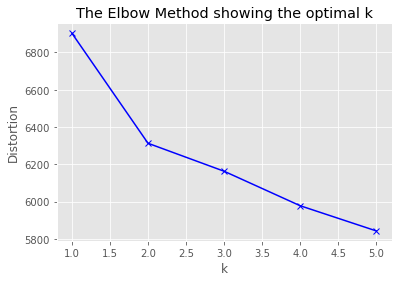

In [47]:
'''
Find best K using elbow method
'''
prData = (originalData, data, (numericalColNames, numericalColIndex, categoricalColNames, categoricalColIndex))
originalData = prData[0]
data = prData[1]
featureList = prData[2]
numericalColNames = featureList[0]
numericalColIndex = featureList[1]
categoricalColNames = featureList[2]
categoricalColIndex = featureList[3]
print("Depict elbow method to detect best K for clustering.....")
if (len(numericalColNames) > 0):
    ''' Combination of numerical and categorical '''
    getBestKPrototype(data, categoricalColIndex)
else:
    getBestKMode(data)


In [48]:
noOfCluster = 3
''' Step4: Cluster PRs data '''
print('NO_OF_CLUSTER', noOfCluster)
print('CLuster PRs....')
if (len(numericalColNames) > 0):
    clustersColn = executeKProtoTypeCluster(data, categoricalColIndex, noOfCluster)
else:
    clustersColn = executeKModeCluster(data, noOfCluster)
clusters = clustersColn[0]
centroids = clustersColn[1]
labels = clustersColn[2]

NO_OF_CLUSTER 3
CLuster PRs....
Initialization method and algorithm are deterministic. Setting n_init to 1.
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 29, cost: 6163.0
Run 1, iteration: 2/100, moves: 0, cost: 6163.0
Cluster Centroids:
[['' '' 'SP5']
 ['' 'US01' 'QKC']
 ['' 'BE25' 'OA9']]
Labels:
[0 0 0 ... 0 0 0]


In [49]:
''' Step5: Replace categorical values in centroids with computed uniqueness values for measuring similarity '''
cenSimilarity = replaceCentroidsWithUniqueness(centroids)
print(cenSimilarity)

[[0, 1, 110], [0, 4, 57], [0, 2, 103]]


In [50]:
''' Step6: Update categorical data for computing similarity  '''
print('.......... Computing cosine similarity ............')
dataSim = data.copy()
cosineSimilarity = computeSimilarity(dataSim, data, cenSimilarity, clusters)
print('Computing cosine similarity completed..')
cosine = cosineSimilarity[0]
dataCnv = cosineSimilarity[1]
print("Silhouette_score:", silhouette_score(dataCnv, labels, metric = 'euclidean'))
print("Calinski-Harabasz_score :", calinski_harabasz_score(dataCnv, labels))
print("Davies_bouldin_score:", davies_bouldin_score(dataCnv, labels))

.......... Computing cosine similarity ............
Computing cosine similarity completed..
Silhouette_score: -0.1873884765632865
Calinski-Harabasz_score : 21.92419752840831
Davies_bouldin_score: 7.382843159612331


In [51]:
''' Add additional columns to original data '''
originalData['cosine'] = cosine
originalData['cluster'] = clusters
print(originalData.head())

''' Step7: Group all clustered PRs with certain confidence level '''
print('Grouping PRs with confidence level > 95% ...')
groupedPRs = groupClusteredPRs(originalData, dataCnv, clusters)
groupPRs = groupedPRs[0]
selectedPRs = groupedPRs[1]
selectedClusters =  groupedPRs[2]    
print("Clustered Groups:",len(groupPRs))

  MANDT       BANFN  BNFPO FLIEF EKORG EKGRP    cosine  cluster
0   100  0518538842  00010        KR01   AJA  0.000000        0
1   100  0522476266  00010               OC5  0.713506        0
2   100  0517585602  00030               UWE  0.898456        0
3   100  0512703893  00030        BE25   OAG  0.842662        2
4   100  0512331530  00010        DE1M   DUV  0.805421        0
Grouping PRs with confidence level > 95% ...
Clustered Groups: 3


In [52]:
''' Step9: Filter PRs based on certain threshold value on grouped PR's '''
print('Filtering PRs with cluster having more than 5 PRs ...')
filteredPRs = filterPRs(groupPRs)
print("Filtered PRs:", len(filteredPRs))

Filtering PRs with cluster having more than 5 PRs ...
Filtered PRs: 3


[0. 0. 0.]
[0.         1.         0.33333333]
[1.         0.         0.86792453]


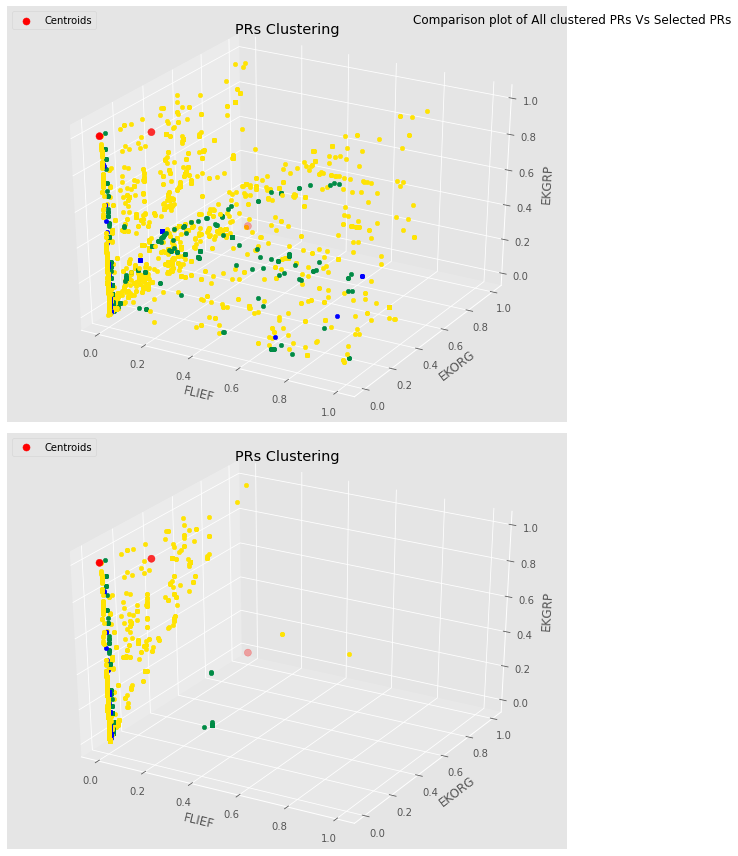

In [53]:
''' Plot cluster graphs '''
#Data normalozation
from sklearn.preprocessing import MinMaxScaler

dataSet = np.array(dataCnv)
# fit scaler on training data
norm = MinMaxScaler().fit(dataSet)

# transform training data
dataSet_norm = norm.transform(dataSet)

selectedPRsData = np.array(selectedPRs)
norm = MinMaxScaler().fit(selectedPRsData)
selectedPRsData_norm = norm.transform(selectedPRsData)

similarity = np.array(cenSimilarity)
norm = MinMaxScaler().fit(similarity)
cenSimilarity_norm = norm.transform(similarity)

drawMultiplePlotClusters(dataSet_norm, clusters, selectedPRsData_norm, selectedClusters, cenSimilarity_norm)

In [54]:
'''
Remove additional columns
Convert to numpy array
'''
print(dataCnv.head())
dataCnv.drop(['EKGRP'], axis = 1, inplace = True)
print(dataCnv.head())

dataSet = dataCnv.to_numpy()
# fit scaler on training data
norm = MinMaxScaler().fit(dataSet)

# transform training data
dataArr = norm.transform(dataSet)
print("Normalized Data: ")
print(dataArr)

print(originalData.head())
originalDataArr = originalData.to_numpy()

  FLIEF EKORG EKGRP
0     0     0     0
1     0     1     1
2     0     1     2
3     0     2     3
4     0     3     4
  FLIEF EKORG
0     0     0
1     0     1
2     0     1
3     0     2
4     0     3
Normalized Data: 
[[0.         0.        ]
 [0.         0.008     ]
 [0.         0.008     ]
 ...
 [0.98663102 0.512     ]
 [1.         0.2       ]
 [0.         0.008     ]]
  MANDT       BANFN  BNFPO FLIEF EKORG EKGRP    cosine  cluster
0   100  0518538842  00010        KR01   AJA  0.000000        0
1   100  0522476266  00010               OC5  0.713506        0
2   100  0517585602  00030               UWE  0.898456        0
3   100  0512703893  00030        BE25   OAG  0.842662        2
4   100  0512331530  00010        DE1M   DUV  0.805421        0


Number of clusters =  2
silhouette_score = 0.6379482408458926
Calinski-Harabasz_score : 3368.812867740398
Davies_bouldin_score: 0.9055296830628575
----------------------------------------------------------
Number of clusters =  3
silhouette_score = 0.7195959787902244
Calinski-Harabasz_score : 7053.796486216857
Davies_bouldin_score: 0.5624600886377348
----------------------------------------------------------
Number of clusters =  4
silhouette_score = 0.7150037318685076
Calinski-Harabasz_score : 6427.70713298567
Davies_bouldin_score: 0.6881099694582284
----------------------------------------------------------
Number of clusters =  5
silhouette_score = 0.6728153252285164
Calinski-Harabasz_score : 6532.367367252363
Davies_bouldin_score: 0.7270564433789912
----------------------------------------------------------
[0.6379482408458926, 0.7195959787902244, 0.7150037318685076, 0.6728153252285164]
[3368.812867740398, 7053.796486216857, 6427.70713298567, 6532.367367252363]
[0.9055296830628575,

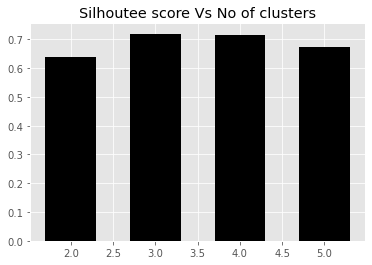

In [55]:
from sklearn.cluster import KMeans

silhouetteScores = []
calinskiHarabaszScores = []
daviesBouldinScores = []
range_values = np.arange(2, NO_OF_CLUSTER)
for i in range_values:
    model = KMeans(init='k-means++', n_clusters=i)
    model.fit(dataArr)    
    print("Number of clusters = ", i)    
    silhouetteScore = silhouette_score(dataArr, model.labels_, metric = 'euclidean', sample_size=len(dataArr))
    print("silhouette_score =", silhouetteScore)    
    silhouetteScores.append(silhouetteScore)
    
    calinskiHarabaszScore = calinski_harabasz_score(dataArr, model.labels_)
    print("Calinski-Harabasz_score :", calinskiHarabaszScore)
    calinskiHarabaszScores.append(calinskiHarabaszScore)
    
    daviesBouldinScore = davies_bouldin_score(dataArr, model.labels_)
    print("Davies_bouldin_score:", daviesBouldinScore) 
    daviesBouldinScores.append(daviesBouldinScore)
    print('----------------------------------------------------------')

print(silhouetteScores)
print(calinskiHarabaszScores)
print(daviesBouldinScores)
#Bar graph to choose the K
plt.bar(range_values, silhouetteScores, width=0.6, color='k', align='center')
plt.title("Silhoutee score Vs No of clusters")
plt.draw()

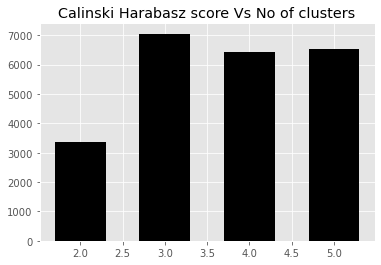

In [56]:
#The score is higher when clusters are dense and well separated.
plt.bar(range_values, calinskiHarabaszScores, width=0.6, color='k', align='center')
plt.title("Calinski Harabasz score Vs No of clusters")
plt.draw()

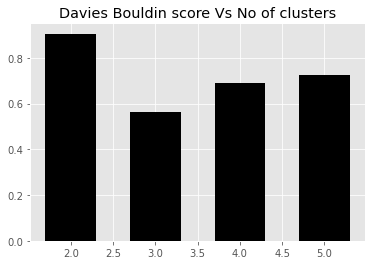

In [57]:
# Zero is the lowest possible score. Values closer to zero indicate a better partition.
plt.bar(range_values, daviesBouldinScores, width=0.6, color='k', align='center')
plt.title("Davies Bouldin score Vs No of clusters")
plt.draw()

#Clusters = 3
Clusters = [0 1 2]
Inertia = 89.44472306879315
Centroids = [[0.01973768 0.04620864]
 [0.05449184 0.56184697]
 [0.69344728 0.2624689 ]]
Grouped Clusters 3
  FLIEF EKORG  CLUSTER
0     0     0        0
1     0     1        0
2     0     1        0
3     0     2        0
4     0     3        0


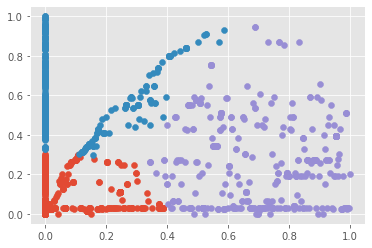

In [58]:
'''
K-Means
K-Means Clustering may be the most widely known clustering algorithm and involves assigning examples to clusters in an 
effort to minimize the variance within each cluster.

The main purpose of this paper is to describe a process for partitioning an N-dimensional population into k sets on the 
basis of a sample. The process, which is called ‘k-means,’ appears to give partitions which are reasonably efficient in 
the sense of within-class variance.
'''
from sklearn.cluster import KMeans
from numpy import unique
from numpy import where

model = KMeans(n_clusters=3)
model.fit(dataArr)
yhat = model.fit_predict(dataArr)
clusters = unique(yhat)
print("#Clusters =", len(clusters))
print("Clusters =", clusters)
print("Inertia =", model.inertia_)
print("Centroids =", model.cluster_centers_)

groupedClusterPRs = {}
# create scatter plot for samples from each cluster
for cluster in clusters:
    # get row indexes for samples with this cluster
    row_ix = where(yhat == cluster)
    # create scatter of these samples
    plt.scatter(dataArr[row_ix, 0], dataArr[row_ix, 1])
    groupedClusterPRs[cluster] = originalDataArr[row_ix, 1]
plt.draw()
print("Grouped Clusters", len(groupedClusterPRs))

#Copy cluster numbers to data for prediction
dataPred = dataCnv.copy()
dataPred['CLUSTER'] = yhat
print(dataPred.head())


In [59]:
orgData = originalData.copy()
orgData.drop(['MANDT', 'BANFN', 'BNFPO', 'EKGRP', 'cosine', 'cluster'], axis = 1, inplace = True)
print(orgData.head())
X = pd.get_dummies(orgData, columns=['FLIEF', 'EKORG'])
print(X.head())
y = originalData['cluster']
print(y.head())

  FLIEF EKORG
0        KR01
1            
2            
3        BE25
4        DE1M
   FLIEF_  FLIEF_0000001000  FLIEF_0000003671  FLIEF_0000005537  \
0       1                 0                 0                 0   
1       1                 0                 0                 0   
2       1                 0                 0                 0   
3       1                 0                 0                 0   
4       1                 0                 0                 0   

   FLIEF_0000026148  FLIEF_0000036305  FLIEF_0000038325  FLIEF_0000053443  \
0                 0                 0                 0                 0   
1                 0                 0                 0                 0   
2                 0                 0                 0                 0   
3                 0                 0                 0                 0   
4                 0                 0                 0                 0   

   FLIEF_0000069505  FLIEF_0000070459  ...  EKORG_

In [60]:
# Fit the classifier with default hyper-parameters
clf = DecisionTreeClassifier(random_state=1234)
model = clf.fit(X, y)

#Decision tree text representation
text_representation = tree.export_text(clf)
print(text_representation)

|--- feature_490 <= 0.50
|   |--- feature_387 <= 0.50
|   |   |--- feature_456 <= 0.50
|   |   |   |--- feature_46 <= 0.50
|   |   |   |   |--- class: 0
|   |   |   |--- feature_46 >  0.50
|   |   |   |   |--- class: 2
|   |   |--- feature_456 >  0.50
|   |   |   |--- feature_135 <= 0.50
|   |   |   |   |--- feature_254 <= 0.50
|   |   |   |   |   |--- feature_111 <= 0.50
|   |   |   |   |   |   |--- feature_0 <= 0.50
|   |   |   |   |   |   |   |--- class: 2
|   |   |   |   |   |   |--- feature_0 >  0.50
|   |   |   |   |   |   |   |--- class: 2
|   |   |   |   |   |--- feature_111 >  0.50
|   |   |   |   |   |   |--- class: 0
|   |   |   |   |--- feature_254 >  0.50
|   |   |   |   |   |--- class: 0
|   |   |   |--- feature_135 >  0.50
|   |   |   |   |--- class: 0
|   |--- feature_387 >  0.50
|   |   |--- class: 2
|--- feature_490 >  0.50
|   |--- class: 1



In [61]:
viz = dtreeviz(clf, X, y,
                target_name="Cluster",
                feature_names=X.columns,
                class_names=['CLUSTER_0', 'CLUSTER_1', 'CLUSTER_2'])

display(HTML(viz.svg()))

Pass classes=[0 1 2], y=[0 0 0 ... 0 0 0] as keyword args. From version 0.25 passing these as positional arguments will result in an error
Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


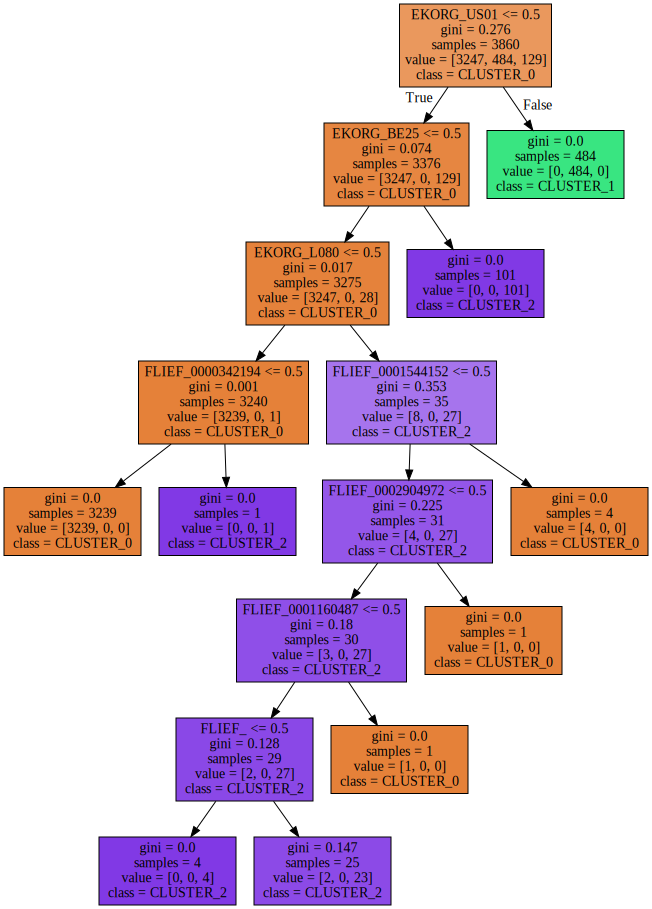

In [62]:
# DOT data
dot_data = tree.export_graphviz(clf, out_file=None, 
                    feature_names=X.columns,
                    class_names=['CLUSTER_0', 'CLUSTER_1', 'CLUSTER_2'],
                    filled=True)
# Draw graph
graph = graphviz.Source(dot_data, format="png") 
graph

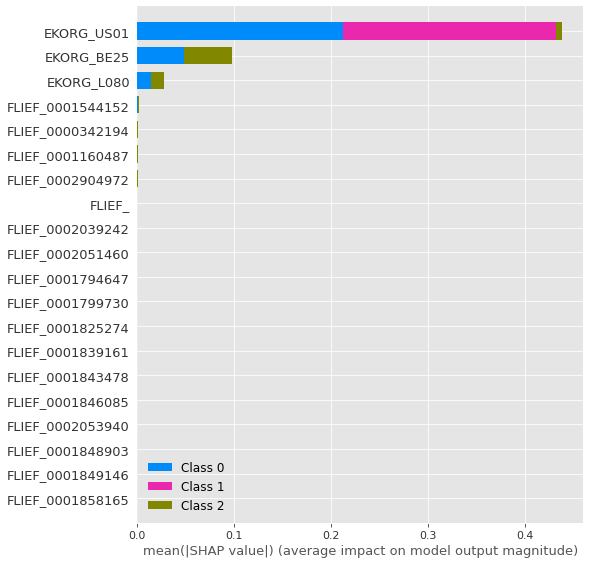

In [63]:
# Shapley values interpretibility
import shap
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)
shap.summary_plot(shap_values, features=X, feature_names=X.columns)

In [77]:
shap.initjs()
sampleData = shap.sample(X, 100)
rf_explainer = shap.KernelExplainer(model.predict, sampleData)
rf_shap_values = rf_explainer.shap_values(sampleData)
shap.force_plot(rf_explainer.expected_value, rf_shap_values, sampleData)

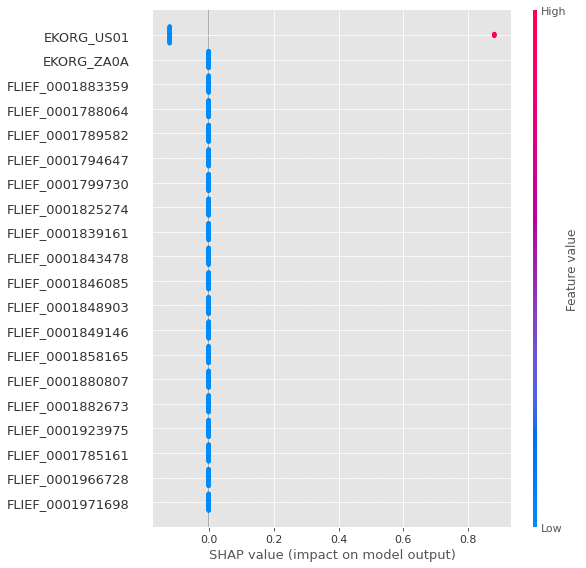

In [80]:
shap.summary_plot(rf_shap_values, sampleData)

In [81]:
# LIME interpretbility
clf_lime = rfc()
clf_lime.fit(X, y)
explainer = LimeTabularExplainer(X, 
                      feature_names=X.columns, 
                      class_names=['CLUSTER_0', 'CLUSTER_1', 'CLUSTER_2'], 
                      discretize_continuous=False, 
                      verbose=True)
# Specific instance
print(X.iloc[[2000]].to_numpy()[0])
lime = explainer.explain_instance(X.iloc[[2000]].to_numpy()[0], clf_lime.predict_proba)
#lime.show_in_notebook(show_table=True)
lime.save_to_file('lime_instance.html')

f = open("lime_instance.html", "r", encoding='utf-8')
display(HTML(f.read()))

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 

#Clusters = 3
Clusters = [0 1 2]
Inertia = 90.33840897324056
Centroids = [[0.08007886 0.56527946]
 [0.01504788 0.04113319]
 [0.7017269  0.20667516]]
Grouped Clusters 3


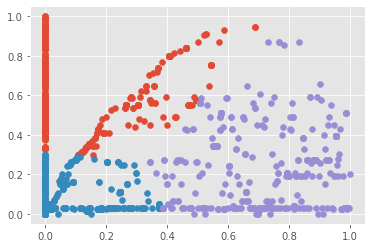

In [82]:
'''
Mini-Batch K-Means
Mini-Batch K-Means is a modified version of k-means that makes updates to the cluster centroids using mini-batches of 
samples rather than the entire dataset, which can make it faster for large datasets, and perhaps more robust to 
statistical noise.
'''
model = MiniBatchKMeans(n_clusters = 3)
model.fit(dataArr)
yhat = model.fit_predict(dataArr)
clusters = unique(yhat)
print("#Clusters =", len(clusters))
print("Clusters =", clusters)
print("Inertia =", model.inertia_)
print("Centroids =", model.cluster_centers_)
groupedClusterPRs = {}
# create scatter plot for samples from each cluster
for cluster in clusters:
    # get row indexes for samples with this cluster
    row_ix = where(yhat == cluster)
    # create scatter of these samples
    plt.scatter(dataArr[row_ix, 0], dataArr[row_ix, 1])
    groupedClusterPRs[cluster] = originalDataArr[row_ix, 1]    
plt.draw()
print("Grouped Clusters", len(groupedClusterPRs))

Epsilon =  0.05 --> Silhouette_score =  0.3027
Epsilon =  0.05 --> Calinski-Harabasz_score =  163.98059791866694
Epsilon =  0.05 --> Davies_bouldin_score =  0.9302174310632199
----------------------------------------------------------
Epsilon =  0.06666666666666667 --> Silhouette_score =  0.5368
Epsilon =  0.06666666666666667 --> Calinski-Harabasz_score =  367.1048249455269
Epsilon =  0.06666666666666667 --> Davies_bouldin_score =  1.1793701985965976
----------------------------------------------------------
Epsilon =  0.08333333333333334 --> Silhouette_score =  0.5038
Epsilon =  0.08333333333333334 --> Calinski-Harabasz_score =  34.655520870807315
Epsilon =  0.08333333333333334 --> Davies_bouldin_score =  0.32613030438077706
----------------------------------------------------------
Epsilon =  0.1 --> Silhouette_score =  0.5042
Epsilon =  0.1 --> Calinski-Harabasz_score =  51.90433537829542
Epsilon =  0.1 --> Davies_bouldin_score =  0.3523649226954353
---------------------------------

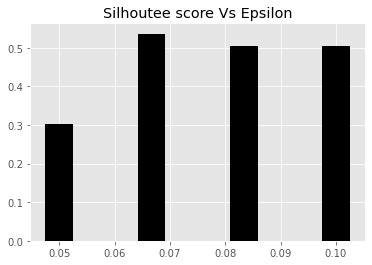

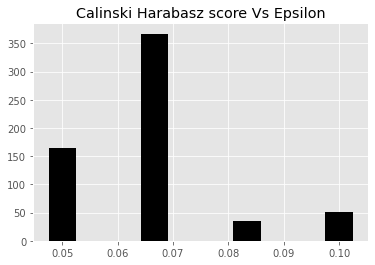

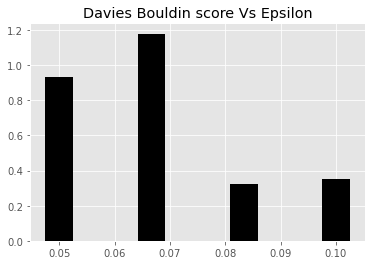

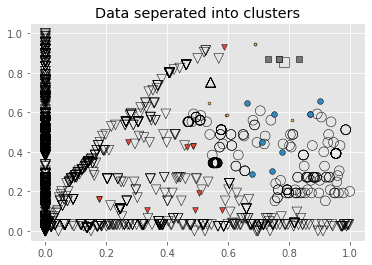

In [83]:
'''
https://www.google.com/search?rlz=1C1CHBD_enIN868IN868&ei=fUBnX5j2I9zUz7sPnf6vmAs&q=Automatically+estimating+the+number+of+clusters+using+DBSCAN+videos&oq=Automatically+estimating+the+number+of+clusters+using+DBSCAN+videos&gs_lcp=CgZwc3ktYWIQAzoECAAQR1DMHVjnLGDbLWgBcAJ4AIABlQOIAekPkgEFMy01LjGYAQCgAQGqAQdnd3Mtd2l6yAEIwAEB&sclient=psy-ab&ved=0ahUKEwjYqLH-0_frAhVc6nMBHR3_C7MQ4dUDCA0&uact=5#kpvalbx=_hEBnX8WoHLDfz7sPhOeuCA32
'''
from sklearn.cluster import DBSCAN
from itertools import cycle

eps_grid = np.linspace(0.05, 0.1, num=4)
silhouetteScores = []
calinskiHarabaszScores = []
daviesBouldinScores = []
eps_best = eps_grid[0]
silhouetteScoreMax = -1
models_best = None
labels_best = None


for eps in eps_grid:
    model = DBSCAN(eps=eps, min_samples=5)
    model.fit(dataArr)
    labels = model.labels_
    score = silhouette_score(dataArr, model.labels_, metric = 'euclidean', sample_size=len(dataArr))
    silhouetteScore = round(score, 4)
    silhouetteScores.append(silhouetteScore)
    print('Epsilon = ', eps, '--> Silhouette_score = ', silhouetteScore)
    
    calinskiHarabaszScore = calinski_harabasz_score(dataArr, model.labels_)
    print('Epsilon = ', eps, '--> Calinski-Harabasz_score = ', calinskiHarabaszScore)
    calinskiHarabaszScores.append(calinskiHarabaszScore)
    
    daviesBouldinScore = davies_bouldin_score(dataArr, model.labels_)
    print('Epsilon = ', eps, '--> Davies_bouldin_score = ', daviesBouldinScore) 
    daviesBouldinScores.append(daviesBouldinScore)
    print('----------------------------------------------------------')
    
    if(silhouetteScore > silhouetteScoreMax):
        silhouetteScoreMax = silhouetteScore
        eps_best = eps
        models_best = model
        labels_best = labels

print(silhouetteScores)
print(calinskiHarabaszScores)
print(daviesBouldinScores)

plt.figure()
plt.bar(eps_grid, silhouetteScores, width=0.005, color='k', align='center')
plt.title("Silhoutee score Vs Epsilon")
plt.draw()

#The score is higher when clusters are dense and well separated.
plt.figure()
plt.bar(eps_grid, calinskiHarabaszScores, width=0.005, color='k', align='center')
plt.title("Calinski Harabasz score Vs Epsilon")
plt.draw()

# Zero is the lowest possible score. Values closer to zero indicate a better partition.
plt.figure()
plt.bar(eps_grid, daviesBouldinScores, width=0.005, color='k', align='center')
plt.title("Davies Bouldin score Vs Epsilon")
plt.draw()

print('Best epsilon = ', eps_best)
eps = eps_best
model = models_best
labels = labels_best

#Check for unassigned data points in the labels
offset = 0
if -1 in labels:
    offset = 1

#number of clusters in the data
num_of_clusters = len(set(labels)) - offset
print('Estimated number of clusters =', num_of_clusters)

mask_core = np.zeros(labels.shape, dtype=np.bool)
mask_core[model.core_sample_indices_] = True

#plot resultant cluster
plt.figure()
labels_uniq = set(labels)
markers = cycle('vo^s<>')
for cur_label, marker in zip(labels_uniq, markers):
    if(cur_label == -1):
        marker = '.'
    
    cur_mask = (labels == cur_label)
    
    cur_data = dataArr[cur_mask & mask_core]
    plt.scatter(cur_data[:, 0], cur_data[:, 1], marker=marker, edgecolors='black', s=96, facecolors='none')

    cur_data = dataArr[cur_mask & ~mask_core]
    plt.scatter(cur_data[:, 0], cur_data[:, 1], marker=marker, edgecolors='black', s=32)
    plt.title('Data seperated into clusters')
plt.show()

#Clusters = 5
Clusters = [-1  0  1  2  3]
Grouped Clusters 5


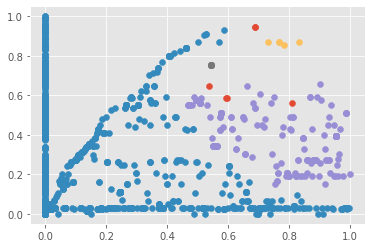

In [84]:
'''
DBSCAN
DBSCAN Clustering (where DBSCAN is short for Density-Based Spatial Clustering of Applications with Noise) involves finding 
high-density areas in the domain and expanding those areas of the feature space around them as clusters.

We present the new clustering algorithm DBSCAN relying on a density-based notion of clusters which is designed to discover 
clusters of arbitrary shape. DBSCAN requires only one input parameter and supports the user in determining an appropriate 
value for it
'''
from numpy import unique
from numpy import where

yhat = model.fit_predict(dataArr)
clusters = unique(yhat)
print("#Clusters =", len(clusters))
print("Clusters =", clusters)
groupedClusterPRs = {}
# create scatter plot for samples from each cluster
for cluster in clusters:
    # get row indexes for samples with this cluster
    row_ix = where(yhat == cluster)
    # create scatter of these samples
    plt.scatter(dataArr[row_ix, 0], dataArr[row_ix, 1])
    groupedClusterPRs[cluster] = originalDataArr[row_ix, 1]    
plt.draw()
print("Grouped Clusters", len(groupedClusterPRs))

Affinity propagation did not converge, this model will not have any cluster centers.
This model does not have any cluster centers because affinity propagation did not converge. Labeling every sample as '-1'.


#Clusters = 1
Clusters = [-1]
Grouped Clusters 1


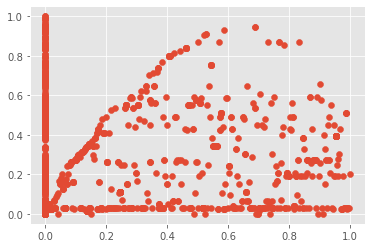

In [85]:
# Affinity Propagation
'''
We devised a method called “affinity propagation,” which takes as input measures of similarity between pairs of data points.
Real-valued messages are exchanged between data points until a high-quality set of exemplars and corresponding clusters gradually emerges
'''

from sklearn.cluster import AffinityPropagation
from numpy import unique

# define the model
model = AffinityPropagation(damping=0.5, random_state=None)
# fit the model
model.fit(dataArr)
# assign a cluster to each example
yhat = model.predict(dataArr)
# retrieve unique clusters
clusters = unique(yhat)
print("#Clusters =", len(clusters))
print("Clusters =", clusters)
groupedClusterPRs = {}
# create scatter plot for samples from each cluster
for cluster in clusters:
    # get row indexes for samples with this cluster
    row_ix = where(yhat == cluster)
    # create scatter of these samples
    plt.scatter(dataArr[row_ix, 0], dataArr[row_ix, 1])
    groupedClusterPRs[cluster] = originalDataArr[row_ix, 1]    
plt.draw()
print("Grouped Clusters", len(groupedClusterPRs))

Number of clusters =  2
silhouette_score = 0.5900823482744922
Calinski-Harabasz_score : 2737.307642858365
Davies_bouldin_score: 1.01413417939578
----------------------------------------------------------
Number of clusters =  3
silhouette_score = 0.6765287282369137
Calinski-Harabasz_score : 4857.43107616779
Davies_bouldin_score: 0.7279560493516009
----------------------------------------------------------
Number of clusters =  4
silhouette_score = 0.6580476359214824
Calinski-Harabasz_score : 4693.799320878526
Davies_bouldin_score: 0.7302787777277748
----------------------------------------------------------
Number of clusters =  5
silhouette_score = 0.6734940606630775
Calinski-Harabasz_score : 5294.741177937972
Davies_bouldin_score: 0.7130607748995758
----------------------------------------------------------
[0.5900823482744922, 0.6765287282369137, 0.6580476359214824, 0.6734940606630775]
[2737.307642858365, 4857.43107616779, 4693.799320878526, 5294.741177937972]
[1.01413417939578, 0.7

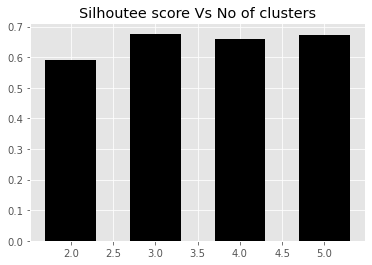

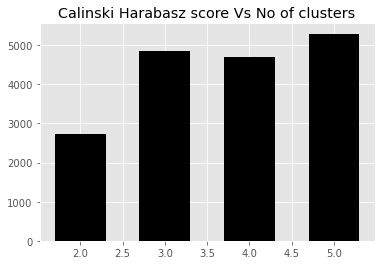

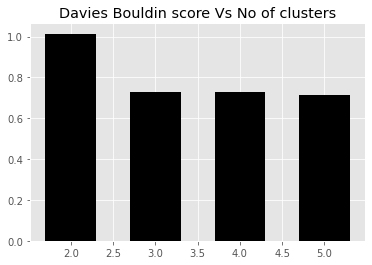

In [86]:
from sklearn.cluster import AgglomerativeClustering

silhouetteScores = []
calinskiHarabaszScores = []
daviesBouldinScores = []

range_values = np.arange(2, NO_OF_CLUSTER)
for i in range_values:
    model = AgglomerativeClustering(n_clusters=i)
    model.fit(dataArr)    
    silhouetteScore = silhouette_score(dataArr, model.labels_, metric = 'euclidean', sample_size=len(dataArr))
    print("Number of clusters = ", i)
    print("silhouette_score =", silhouetteScore)
    silhouetteScores.append(silhouetteScore)
    
    calinskiHarabaszScore = calinski_harabasz_score(dataArr, model.labels_)
    print("Calinski-Harabasz_score :", calinskiHarabaszScore)
    calinskiHarabaszScores.append(calinskiHarabaszScore)
    
    daviesBouldinScore = davies_bouldin_score(dataArr, model.labels_)
    print("Davies_bouldin_score:", daviesBouldinScore) 
    daviesBouldinScores.append(daviesBouldinScore)
    print('----------------------------------------------------------')
    
print(silhouetteScores)
print(calinskiHarabaszScores)
print(daviesBouldinScores)

#Bar graph to choose the K
plt.figure()
plt.bar(range_values, silhouetteScores, width=0.6, color='k', align='center')
plt.title("Silhoutee score Vs No of clusters")
plt.draw()

#The score is higher when clusters are dense and well separated.
plt.figure()
plt.bar(range_values, calinskiHarabaszScores, width=0.6, color='k', align='center')
plt.title("Calinski Harabasz score Vs No of clusters")
plt.draw()

#Zero is the lowest possible score. Values closer to zero indicate a better partition.
plt.figure()
plt.bar(range_values, daviesBouldinScores, width=0.6, color='k', align='center')
plt.title("Davies Bouldin score Vs No of clusters")
plt.draw()

#Clusters = 3
Clusters = [0 1 2]
Grouped Clusters 3


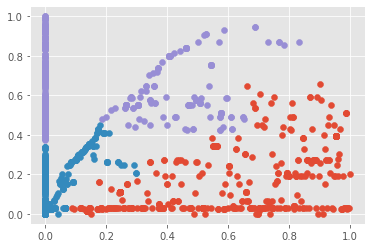

In [87]:
'''
Agglomerative Clustering:
Agglomerative clustering involves merging examples until the desired number of clusters is achieved.
It is a part of a broader class of hierarchical clustering methods
'''
from sklearn.cluster import AgglomerativeClustering

model = AgglomerativeClustering(n_clusters=3)
model.fit(dataArr)
yhat = model.fit_predict(dataArr)
clusters = unique(yhat)
print("#Clusters =", len(clusters))
print("Clusters =", clusters)
groupedClusterPRs = {}
# create scatter plot for samples from each cluster
for cluster in clusters:
    # get row indexes for samples with this cluster
    row_ix = where(yhat == cluster)
    # create scatter of these samples
    plt.scatter(dataArr[row_ix, 0], dataArr[row_ix, 1])
    groupedClusterPRs[cluster] = originalDataArr[row_ix, 1]    
plt.draw()
print("Grouped Clusters", len(groupedClusterPRs))

Number of clusters =  2
silhouette_score = 0.6459090794397024
Calinski_Harabasz_score : 2752.4422002085644
Davies_bouldin_score: 0.7456275855709115
----------------------------------------------------------
Number of clusters =  3
silhouette_score = 0.5787817470633904
Calinski_Harabasz_score : 1793.0388665033151
Davies_bouldin_score: 0.6651480470701718
----------------------------------------------------------
Number of clusters =  4
silhouette_score = 0.42559495396780694
Calinski_Harabasz_score : 1498.1507500255632
Davies_bouldin_score: 0.8538318990675056
----------------------------------------------------------
Number of clusters =  5
silhouette_score = 0.48427910319899276
Calinski_Harabasz_score : 2351.562091681338
Davies_bouldin_score: 0.7675858701063121
----------------------------------------------------------
[0.6459090794397024, 0.5787817470633904, 0.42559495396780694, 0.48427910319899276]
[2752.4422002085644, 1793.0388665033151, 1498.1507500255632, 2351.562091681338]
[0.74562

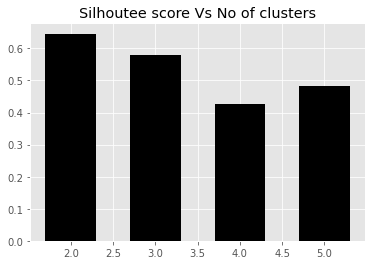

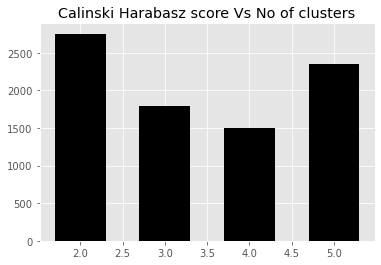

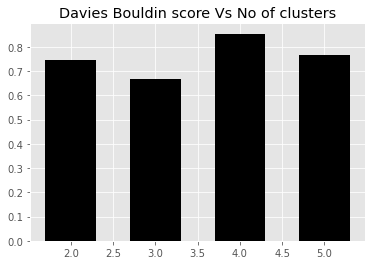

In [88]:
from sklearn.cluster import Birch

silhouetteScores = []
calinskiHarabaszScores = []
daviesBouldinScores = []

range_values = np.arange(2, NO_OF_CLUSTER)
for i in range_values:
    model = Birch(threshold=0.05, n_clusters=i)
    model.fit(dataArr)    
    silhouetteScore = silhouette_score(dataArr, model.labels_, metric = 'euclidean', sample_size=len(dataArr))
    print("Number of clusters = ", i)
    print("silhouette_score =", silhouetteScore)
    silhouetteScores.append(silhouetteScore)
    
    calinskiHarabaszScore = calinski_harabasz_score(dataArr, model.labels_)
    print("Calinski_Harabasz_score :", calinskiHarabaszScore)
    calinskiHarabaszScores.append(calinskiHarabaszScore)
    
    daviesBouldinScore = davies_bouldin_score(dataArr, model.labels_)
    print("Davies_bouldin_score:", daviesBouldinScore) 
    daviesBouldinScores.append(daviesBouldinScore)
    print('----------------------------------------------------------')    
    
print(silhouetteScores)
print(calinskiHarabaszScores)
print(daviesBouldinScores)

#Bar graph to choose the K
plt.figure()
plt.bar(range_values, silhouetteScores, width=0.6, color='k', align='center')
plt.title("Silhoutee score Vs No of clusters")
plt.draw()

#The score is higher when clusters are dense and well separated.
plt.figure()
plt.bar(range_values, calinskiHarabaszScores, width=0.6, color='k', align='center')
plt.title("Calinski Harabasz score Vs No of clusters")
plt.draw()

#Zero is the lowest possible score. Values closer to zero indicate a better partition.
plt.figure()
plt.bar(range_values, daviesBouldinScores, width=0.6, color='k', align='center')
plt.title("Davies Bouldin score Vs No of clusters")
plt.draw()

#Clusters = 3
Clusters = [0 1 2]
Grouped Clusters 3


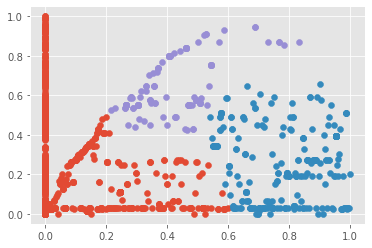

In [89]:
'''
BIRCH
BIRCH Clustering (BIRCH is short for Balanced Iterative Reducing and Clustering using
Hierarchies) involves constructing a tree structure from which cluster centroids are extracted.

BIRCH incrementally and dynamically clusters incoming multi-dimensional metric data points to try to produce the 
best quality clustering with the available resources (i. e., available memory and time constraints).
'''

from sklearn.cluster import Birch
model = Birch(threshold=0.05, n_clusters=3)
model.fit(dataArr)
yhat = model.fit_predict(dataArr)
clusters = unique(yhat)
print("#Clusters =", len(clusters))
print("Clusters =", clusters)
groupedClusterPRs = {}
# create scatter plot for samples from each cluster
for cluster in clusters:
    # get row indexes for samples with this cluster
    row_ix = where(yhat == cluster)
    # create scatter of these samples
    plt.scatter(dataArr[row_ix, 0], dataArr[row_ix, 1])
    groupedClusterPRs[cluster] = originalDataArr[row_ix, 1]    
plt.draw()
print("Grouped Clusters", len(groupedClusterPRs))

Number of clusters =  2
silhouette_score = 0.4748553509276235
Calinski-Harabasz_score : 2030.917480490928
Davies_bouldin_score: 0.930443322816487
----------------------------------------------------------
Number of clusters =  3
silhouette_score = 0.4712670528384238
Calinski-Harabasz_score : 2187.651069571207
Davies_bouldin_score: 1.0989792643676937
----------------------------------------------------------
Number of clusters =  4
silhouette_score = 0.4770150103566213
Calinski-Harabasz_score : 2197.934481133043
Davies_bouldin_score: 1.7065032398441133
----------------------------------------------------------
Number of clusters =  5
silhouette_score = 0.4675496031558683
Calinski-Harabasz_score : 1951.9310399637313
Davies_bouldin_score: 1.2440740871849947
----------------------------------------------------------
[0.4748553509276235, 0.4712670528384238, 0.4770150103566213, 0.4675496031558683]
[2030.917480490928, 2187.651069571207, 2197.934481133043, 1951.9310399637313]
[0.93044332281648

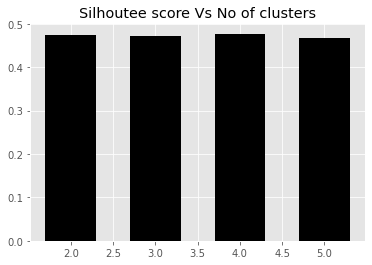

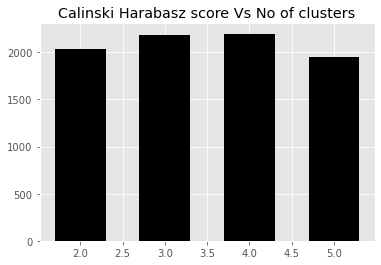

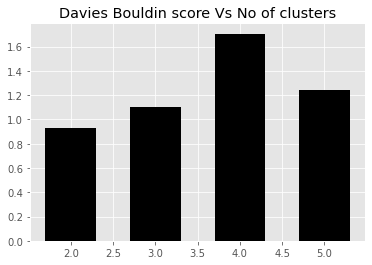

In [90]:
from sklearn.mixture import GaussianMixture

silhouetteScores = []
calinskiHarabaszScores = []
daviesBouldinScores = []
range_values = np.arange(2, NO_OF_CLUSTER)
for i in range_values:
    model = GaussianMixture(n_components=i)
    model.fit(dataArr)
    labels = model.fit_predict(dataArr)    
    silhouetteScore = silhouette_score(dataArr, labels, metric = 'euclidean', sample_size=len(dataArr))
    print("Number of clusters = ", i)
    print("silhouette_score =", silhouetteScore)
    silhouetteScores.append(silhouetteScore)
    
    calinskiHarabaszScore = calinski_harabasz_score(dataArr, labels)
    print("Calinski-Harabasz_score :", calinskiHarabaszScore)
    calinskiHarabaszScores.append(calinskiHarabaszScore)
    
    daviesBouldinScore = davies_bouldin_score(dataArr, labels)
    print("Davies_bouldin_score:", daviesBouldinScore) 
    daviesBouldinScores.append(daviesBouldinScore)
    print('----------------------------------------------------------')
    
print(silhouetteScores)
print(calinskiHarabaszScores)
print(daviesBouldinScores)

#Bar graph to choose the K
plt.bar(range_values, silhouetteScores, width=0.6, color='k', align='center')
plt.title("Silhoutee score Vs No of clusters")
plt.draw()

#The score is higher when clusters are dense and well separated.
plt.figure()
plt.bar(range_values, calinskiHarabaszScores, width=0.6, color='k', align='center')
plt.title("Calinski Harabasz score Vs No of clusters")
plt.draw()

#Zero is the lowest possible score. Values closer to zero indicate a better partition.
plt.figure()
plt.bar(range_values, daviesBouldinScores, width=0.6, color='k', align='center')
plt.title("Davies Bouldin score Vs No of clusters")
plt.draw()

#Clusters = 3
Clusters = [0 1 2]
Grouped Clusters 3


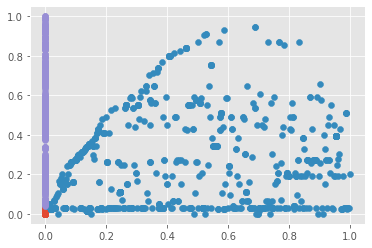

In [91]:
'''
Gaussian Mixture Model
A Gaussian mixture model summarizes a multivariate probability density function with a mixture of Gaussian probability 
distributions as its name suggests.
'''

from sklearn.mixture import GaussianMixture
model = GaussianMixture(n_components = 3)
model.fit(dataArr)
yhat = model.fit_predict(dataArr)
clusters = unique(yhat)
print("#Clusters =", len(clusters))
print("Clusters =", clusters)
groupedClusterPRs = {}
# create scatter plot for samples from each cluster
for cluster in clusters:
    # get row indexes for samples with this cluster
    row_ix = where(yhat == cluster)
    # create scatter of these samples
    plt.scatter(dataArr[row_ix, 0], dataArr[row_ix, 1])
    groupedClusterPRs[cluster] = originalDataArr[row_ix, 1]    
plt.draw()
print("Grouped Clusters", len(groupedClusterPRs))

#Clusters = 5
Clusters = [0 1 2 3 4]
Grouped Clusters 5


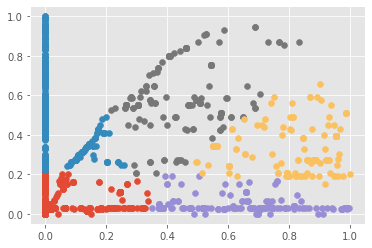

In [92]:
'''
Mean Shift
Mean shift clustering involves finding and adapting centroids based on the density of examples in the feature space.

We prove for discrete data the convergence of a recursive mean shift procedure to the nearest stationary point of the 
underlying density function and thus its utility in detecting the modes of the density.
'''
from sklearn.cluster import MeanShift

model = MeanShift()
model.fit(dataArr)
yhat = model.fit_predict(dataArr)
clusters = unique(yhat)
print("#Clusters =", len(clusters))
print("Clusters =", clusters)
groupedClusterPRs = {}
# create scatter plot for samples from each cluster
for cluster in clusters:
    # get row indexes for samples with this cluster
    row_ix = where(yhat == cluster)
    # create scatter of these samples
    plt.scatter(dataArr[row_ix, 0], dataArr[row_ix, 1])
    groupedClusterPRs[cluster] = originalDataArr[row_ix, 1]    
plt.draw()
print("Grouped Clusters", len(groupedClusterPRs))

divide by zero encountered in true_divide
divide by zero encountered in true_divide


#Clusters = 33
Clusters = [-1  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22
 23 24 25 26 27 28 29 30 31]
Grouped Clusters 33


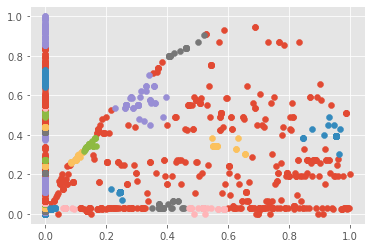

In [93]:
'''
OPTICS
OPTICS clustering (where OPTICS is short for Ordering Points To Identify the Clustering Structure) is a modified version 
of DBSCAN described above.

We introduce a new algorithm for the purpose of cluster analysis which does not produce a clustering of a data set 
explicitly; but instead creates an augmented ordering of the database representing its density-based clustering structure. 
This cluster-ordering contains information which is equivalent to the density-based clusterings corresponding to a 
broad range of parameter settings.
'''

from sklearn.cluster import OPTICS
model = OPTICS(eps=1.5, min_samples=25)
model.fit(dataArr)
yhat = model.fit_predict(dataArr)
clusters = unique(yhat)
print("#Clusters =", len(clusters))
print("Clusters =", clusters)
groupedClusterPRs = {}
# create scatter plot for samples from each cluster
for cluster in clusters:
    # get row indexes for samples with this cluster
    row_ix = where(yhat == cluster)
    # create scatter of these samples
    plt.scatter(dataArr[row_ix, 0], dataArr[row_ix, 1])
    groupedClusterPRs[cluster] = originalDataArr[row_ix, 1]    
plt.draw()
print("Grouped Clusters", len(groupedClusterPRs))